In [717]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [718]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.environ["HUGGINGFACE_API_KEY"]
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [719]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
from typing import Annotated
from typing import TypedDict
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain.tools import tool

In [720]:
llm=ChatGroq(model="gemma2-9b-it")

In [721]:
llm.invoke("what is deep learning")

AIMessage(content='Deep learning is a type of machine learning that uses artificial neural networks with multiple layers to extract increasingly complex features from data. \n\nThink of it like this:\n\n* **Traditional machine learning:** You have to manually tell the algorithm what features to look for in the data. For example, if you want to teach a machine to recognize cats in pictures, you might tell it to look for features like pointy ears, whiskers, and a fluffy tail.\n\n* **Deep learning:** The algorithm learns these features automatically, layer by layer. The first layers might detect simple features like edges and curves, while the deeper layers combine these features to recognize more complex patterns, eventually leading to the recognition of a cat.\n\n**Here\'s a breakdown:**\n\n* **Artificial Neural Networks:** Deep learning algorithms are based on artificial neural networks, which are inspired by the structure of the human brain. These networks consist of interconnected no

In [722]:
embedding=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [723]:
from langchain_community.document_loaders import TextLoader
loader=TextLoader('sample.txt')
docs=loader.load()
docs

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [724]:
document=RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=50).split_documents(docs)
document

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [725]:
vectordb=FAISS.from_documents(document,embedding)

In [726]:
db=vectordb.as_retriever()

In [727]:
ret_doc=db.invoke("what is deep learning")

In [728]:
ret_doc

[Document(id='e5a2f76f-ee88-4ab6-a6cd-1704181fa89b', metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Le

In [729]:
for doc in ret_doc:
    print(doc)

page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.

In a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.

Deep Learning - Geeksforgeeks
Scope of Deep Learning

Today Deep learning AI has become one of the most popular and visible areas of machin

In [730]:
prompt=ChatPromptTemplate.from_template(
    """
        Answer the following question based on the give context
        {context}

        question:{question}  
   """
)

In [731]:
chain=prompt|llm|StrOutputParser()

In [732]:
response=chain.invoke({"context":document,"question":"disadvanatge of deep learning"})

In [733]:
response

'Here are some disadvantages of deep learning, based on the provided text:\n\n* **High computational requirements:** Training deep learning models demands significant processing power and large amounts of data. This can be expensive and time-consuming.\n* **Requires large amounts of labeled data:** Deep learning models often perform best when trained on extensive labeled datasets. Gathering and labeling this data can be a laborious and costly process.\n* **Interpretability:** Deep learning models are often considered "black boxes" because it can be difficult to understand how they arrive at their predictions. This lack of transparency can make it challenging to trust and debug these models.\n* **Overfitting:** Deep learning models can sometimes overfit to the training data, meaning they perform well on the data they were trained on but poorly on new, unseen data.  \n* **Black-box nature:** The complexity of deep learning models makes it difficult to understand the reasoning behind thei

In [734]:
class Grader(BaseModel):
    """check the relevance between the document and question"""
    binary_score:str=Field(description="the relevance of binary score 'yes' or 'no'")

In [735]:
with_structured=llm.with_structured_output(Grader)

system1="""
 As you are grader assissting agent analyse the given question check 
 strictly if the given document contain any keyward or semantic meaning to the givenquestion 
 if you find any relevance to the question say strictly binary_score 'yes' otherwise 'no'
"""

prompt1=ChatPromptTemplate.from_messages(
    [
        ("system",system1),
        ("human","Here is the question :{question}/n/n Here is the document : {document}")
    ]
)

grade_docs=prompt1|with_structured

In [736]:
question="who is president os india"

In [737]:
grade_docs.invoke({"question":question,"document":ret_doc})

Grader(binary_score='no')

In [738]:
system2="""
 As you are a question rewritter take the given question and analyse it
 reformulate the given question into better version for the web searching otherwise you
 nothing do in the question
return the rewritting question only 
"""

prompt2=ChatPromptTemplate.from_messages(
    [("system",system2),
     ("human","Here is the question {question}")]
)

question_rewritter=prompt2|llm

In [739]:
question1="president of india"

In [740]:
result=question_rewritter.invoke({"question":question1})

In [741]:
result

AIMessage(content='Who is the current President of India? \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 62, 'total_tokens': 74, 'completion_time': 0.021818182, 'prompt_time': 0.00332401, 'queue_time': 0.132054955, 'total_time': 0.025142192}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-7fef90ec-3859-4a99-9376-73328273767e-0', usage_metadata={'input_tokens': 62, 'output_tokens': 12, 'total_tokens': 74})

In [742]:
prompt3=ChatPromptTemplate.from_template(
    """
        Answer the following question based on the give context
        {context}

        question:{question}  
   """
)

query_gen=prompt3|llm

In [743]:
from typing import List

In [744]:
class AgentState(TypedDict):
    question:str
    generation:str
    toolsearch:str
    web_search:str
    documents:list[str]

In [745]:
def retriever(state:AgentState):

    print("==> RETRIEVING THE QUESTION <===")
    question=state["question"]

    documents=db.invoke(question)
    return {"question":question,"documents":documents}

In [746]:
#retriever({"question":"what is deep learning"})

In [747]:
def grade_checking(state:AgentState):

    print("==> GRADE CHECKING <==")

    question=state["question"]
    documents=state["documents"]

    web_search='no'
    doclist=[]

    for doc in documents:
        grade=grade_docs.invoke({"question":question,"document":doc.page_content})
        score=grade.binary_score

        if score=='yes':
            print("==> DOCUMENTS ARE RELEVANTS <===")
            doclist.append(doc)

        else:
            print("DOCUMENTS ARE NOT RELEVANT")
            web_search='yes'
            continue
    
    return {"question":question,"documents":doclist,"web_search":web_search}

In [748]:
def router(state:AgentState):
    question=state["question"]
    web_search=state["web_search"]

    if web_search=='yes':
        return "transform_query"
    else:
        return "generate_answer" 

In [749]:
def generate(state:AgentState):
    print("==> GENERATING THE ANSWER <==")
    question=state["question"]
    documents=state["documents"]

    generation=query_gen.invoke({"question":question,"context":documents})

    return {"generation":generation}

In [750]:
def rewritting(state:AgentState):

    print("==> REWRITTING THE QUESTION <==")
    question=state["question"]
    documents=state["documents"]

    betterquestion=question_rewritter.invoke({"question":question})

    print(f"the rewrite question is : {betterquestion}")

    return {"question":betterquestion,"documents":documents}

In [751]:
from typing import Literal
import random

In [752]:
def websearching(state:AgentState):
    print("==>ENTERING INTO THE WEB SEARCH <==")

    question=state["question"]
    try:
        if random.randint(0,10)<5:
            toolsearch='tavily'
        else:
            toolsearch='wikipedia'

    except Exception as e:
        print("TypeError: 'dict' object is not callable")

    print(f"the type of tool search is  {toolsearch}")

    return {"toolsearch":toolsearch}

In [753]:
def agent(state:AgentState):
    toolsearch=state["toolsearch"]

    if toolsearch=="tavily":
        return "tavily_tool"
    else :
        return "wikipedia_tool"

In [754]:
search=TavilySearchResults()

In [755]:
def tavily_tool(state:AgentState):

    print("===> ENTERING INTO THE TAVILY SEARCH <===")
    
    question=state["question"].content

    print(f"the question is {question}")

    documents=state["documents"]

    print(f"the documents is {documents}")

    results=search.invoke(question)

    answer='\n\n'.join([r["content"] for r in results])
    
    doc_ans=Document(page_content=answer)

    print(f"the answer is {doc_ans}")

    documents.append(doc_ans)

    return {"question":question,"documents":documents}

In [756]:
wiki_api=WikipediaAPIWrapper(top_k_results=3,doc_content_chars_max=250)
wiki=WikipediaQueryRun(api_wrapper=wiki_api)

In [757]:
from langchain.schema import Document

In [758]:
def wiki_tool(state:AgentState):
    print("==> ENTERING INTO THE WIKI_TOOL <==")
    
    question=state["question"].content

    print(f"the question is {question}")

    documents=state["documents"]

    print(f"the document is {documents}")

    answer=wiki.invoke(question)

    result=Document(page_content=answer)

    print(f"the answer is {result}")

    documents.append(result)
    return {"question":question,"documents":documents}

In [759]:
def grade_checking_want(state:AgentState):

    print("==>ENTERING INTO THE GRADE CHECKING <===")
    question=state["question"]

    if random.randint(1,10)<5:
        return "grade_checking"
    else:
        return "generate"

In [760]:
graph=StateGraph(AgentState)

In [761]:
graph.add_node("retrieving",retriever)
graph.set_entry_point("retrieving")
graph.add_node("grading_documents",grade_checking)
graph.add_node("generating",generate)
graph.add_node("rewritting_query",rewritting)
graph.add_node("websearching_call",websearching)
graph.add_node("tavilytoolsearch",tavily_tool)
graph.add_node("wikipediatoolsearch",wiki_tool)

In [762]:
graph.add_conditional_edges("grading_documents",
                            router,
                            {
                                "transform_query":"rewritting_query",
                                "generate_answer":"generating"
                            })

In [763]:
graph.add_conditional_edges("websearching_call",
                            agent,
                            {
                                "tavily_tool":"tavilytoolsearch",
                                "wikipedia_tool":"wikipediatoolsearch",
                            })

In [764]:
graph.add_conditional_edges("tavilytoolsearch",
                            grade_checking_want,
                            {
                                "grade_checking":"grading_documents",
                                "generate":"generating"
                            }
                            )

In [765]:
graph.add_conditional_edges("wikipediatoolsearch",
                            grade_checking_want,
                            {
                                "grade_checking":"grading_documents",
                                "generate":"generating"
                            }
                            )

In [766]:
graph.add_edge("retrieving","grading_documents")
graph.add_edge("grading_documents","generating")
graph.add_edge("rewritting_query","websearching_call")
graph.add_edge("generating",END)


In [767]:
app=graph.compile()

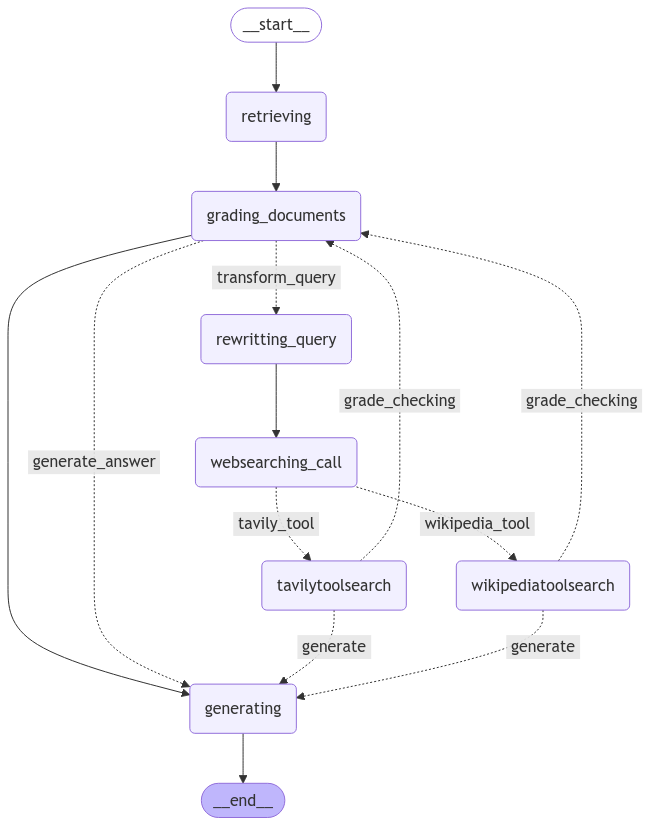

In [768]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [769]:
from pprint import pprint
input={'question':"what is deep learning"}

In [770]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

==> RETRIEVING THE QUESTION <===
node retrieving
'/n.../n'
==> GRADE CHECKING <==
==> DOCUMENTS ARE RELEVANTS <===
==> DOCUMENTS ARE RELEVANTS <===
==> DOCUMENTS ARE RELEVANTS <===
==> DOCUMENTS ARE RELEVANTS <===
node grading_documents
'/n.../n'
==> GENERATING THE ANSWER <==
node generating
'/n.../n'
AIMessage(content='Deep learning is a branch of machine learning that utilizes artificial neural network architecture to learn hidden patterns and relationships within data. \n\nEssentially, it mimics the way the human brain works by using interconnected nodes (neurons) that process and learn from input data through multiple layers. This layered structure allows deep learning models to extract increasingly complex representations of the data, making them powerful for tasks like image recognition, natural language processing, and more. \n\n\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1287, 'total_tokens': 1376, 'completion_time': 0

In [771]:
input2={'question':"president of india"}

In [772]:
for output in app.stream(input2):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

==> RETRIEVING THE QUESTION <===
node retrieving
'/n.../n'
==> GRADE CHECKING <==
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
node grading_documents
'/n.../n'
==> GENERATING THE ANSWER <==
==> REWRITTING THE QUESTION <==
node generating
'/n.../n'
the rewrite question is : content='Who is the current President of India? \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 62, 'total_tokens': 74, 'completion_time': 0.021818182, 'prompt_time': 0.001854974, 'queue_time': 0.04864477, 'total_time': 0.023673156}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-8d43c34b-4ab9-4384-8f98-8b9303949b10-0' usage_metadata={'input_tokens': 62, 'output_tokens': 12, 'total_tokens': 74}
node rewritting_query
'/n.../n'
==>ENTERING INTO THE WEB SEARCH <==
the type of tool search is  tavily
node websearching_call
'/n.../n'
==

In [773]:
input3={'question':"which day india is celebrated as republic day"}

In [774]:
for output in app.stream(input3):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

==> RETRIEVING THE QUESTION <===
node retrieving
'/n.../n'
==> GRADE CHECKING <==
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
node grading_documents
'/n.../n'
==> GENERATING THE ANSWER <==
==> REWRITTING THE QUESTION <==
node generating
'/n.../n'
the rewrite question is : content='When is Republic Day celebrated in India? \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 67, 'total_tokens': 79, 'completion_time': 0.021818182, 'prompt_time': 0.002534793, 'queue_time': 0.049558482, 'total_time': 0.024352975}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-1d402a58-d6f8-44dc-a348-9ac4626a3984-0' usage_metadata={'input_tokens': 67, 'output_tokens': 12, 'total_tokens': 79}
node rewritting_query
'/n.../n'
==>ENTERING INTO THE WEB SEARCH <==
the type of tool search is  tavily
node websearching_call
'/n.../n

In [776]:
input4={'question':"which day india is celebrated as independance day"}

In [777]:
for output in app.stream(input4):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

==> RETRIEVING THE QUESTION <===
node retrieving
'/n.../n'
==> GRADE CHECKING <==
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
DOCUMENTS ARE NOT RELEVANT
node grading_documents
'/n.../n'
==> GENERATING THE ANSWER <==
==> REWRITTING THE QUESTION <==
node generating
'/n.../n'
the rewrite question is : content="When is India's Independence Day celebrated? \n" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 68, 'total_tokens': 81, 'completion_time': 0.023636364, 'prompt_time': 0.001870055, 'queue_time': 0.04983409, 'total_time': 0.025506419}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-bad0e422-ebcd-41b4-bdf4-baaf6f26c8b2-0' usage_metadata={'input_tokens': 68, 'output_tokens': 13, 'total_tokens': 81}
node rewritting_query
'/n.../n'
==>ENTERING INTO THE WEB SEARCH <==
the type of tool search is  wikipedia
node websearching_call
'/n